In [2]:
import sys
import os
sys.path.append("/content/ml-project-2-pytyeee/")
REPO_DIR = "ml-project-2-pytyeee/"

In [3]:
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scripts.preprocessing import *
from helpers.model_handler import *

In [4]:
NUM_CPU = os.cpu_count() if os.cpu_count() is not None else 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE, NUM_CPU)

TRAINING_SIZE = 900
BATCH_SIZE = 32
NUM_EPOCHS = 80
BASE_LR = 0.001

ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

cuda 2


In [5]:
train_dir = REPO_DIR + "dataset/training/"
train_images_filename = train_dir + "augmented_images_big/"
train_masks_filename = train_dir + "augmented_groundtruth_big/"

train_images = extract_data(train_images_filename, TRAINING_SIZE)
train_masks = extract_data(train_masks_filename, TRAINING_SIZE)
print(f"Input shapes: {train_images.shape, train_masks.shape}")

Loading ml-project-2-pytyeee/dataset/training/augmented_images_big/satImage_001.png
Loading ml-project-2-pytyeee/dataset/training/augmented_images_big/satImage_900.png
Loading ml-project-2-pytyeee/dataset/training/augmented_groundtruth_big/satImage_001.png
Loading ml-project-2-pytyeee/dataset/training/augmented_groundtruth_big/satImage_900.png
Input shapes: ((900, 416, 416, 3), (900, 416, 416))


In [6]:
train_data = torch.from_numpy(np.transpose(train_images, (0, 3, 1, 2)))
train_labels = torch.from_numpy(np.transpose(np.expand_dims(train_masks, -1), (0, 3, 1, 2)))

# 1 hot encode each non black pixel to 1 pixel
train_labels[train_labels > 0] = 1
print(f"New shapes: {train_data.shape, train_labels.shape}")

New shapes: ((900, 3, 416, 416), (900, 1, 416, 416))


In [ ]:
train_data, val_data, train_labels, val_labels = split_data(train_data, train_labels, 0.7, seed=438)

Data split on ratio 0.7: TRAINING torch.Size([560, 3, 416, 416]) & torch.Size([560, 1, 416, 416]) and TEST torch.Size([240, 3, 416, 416]) & torch.Size([240, 1, 416, 416])


In [ ]:
# Create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1, # 1 for grayscale
    activation=ACTIVATION,
)

model = model.to(DEVICE)
# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 223MB/s]


In [ ]:
VAL_SIZE = 64 # val_data.shape[0]
print(VAL_SIZE)

# Create datasets
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)

# Get train data loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_CPU)
val_loader = DataLoader(val_dataset, batch_size=VAL_SIZE, shuffle=False, num_workers=NUM_CPU)

64


In [ ]:
# define loss
criterion = smp.losses.DiceLoss('binary')

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR)

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, val_loader, epoch, device):
    # ***************************************************
    # Set model to training mode (affects dropout, batch norm e.g.)
    model.train()

    tr_loss_history = []
    tr_accuracy_history = []
    lr_history = []

    loss_history = []
    accuracy_history = []
    f1_score_history = []
    iou_score_history = []

    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        tr_loss = criterion(output, target)
        tr_loss.backward()
        optimizer.step()
        scheduler.step()

        tp, fp, fn, tn = smp.metrics.get_stats(output, target.to(int), mode='binary', threshold=0.5)
        tr_accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").item()
        tr_loss_float = tr_loss.item()

        print(
            f"Train Epoch: {epoch}-{batch_idx:03d} "
            f"batch_loss={tr_loss_float:0.2e} "
            f"batch_acc={tr_accuracy:0.3f} "
            f"lr={scheduler.get_last_lr()[0]:0.3e} "
        )

        tr_loss_history.append(tr_loss_float)
        tr_accuracy_history.append(tr_accuracy)
        lr_history.append(scheduler.get_last_lr()[0])

    model.eval()
    # Add validation loss, iou, f1 and accuracy
    img_loss, img_iou, img_f1, img_acc = [], [], [], []

    with torch.no_grad():

      for val_idx, (data, target) in enumerate(val_loader):

        data, target = data.to(device), target.to(device)
        output = model(data)

        tp, fp, fn, tn = smp.metrics.get_stats(output, target.to(int), mode='binary', threshold=0.5)

        img_loss.append(criterion(output, target).item())
        img_iou.append(smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro"))
        img_f1.append(smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro"))
        img_acc.append(smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro"))

    loss = np.mean(img_loss)
    iou_score = np.mean([t.item() for t in img_iou])
    f1_score = np.mean([t.item() for t in img_f1])
    accuracy = np.mean([t.item() for t in img_acc])

    print(
        f"\nValidation: "
        f"loss={loss:0.2e} "
        f"accuracy={accuracy:0.3f} "
        f"iou_score={iou_score:0.3f} "
        f"f1_score={f1_score:0.3f}\n"
    )

    return tr_loss_history, tr_accuracy_history, lr_history, loss, accuracy, f1_score, iou_score, output, target

In [ ]:
lrs = []
tr_losses = []
tr_accs = []
losses = []
ious = []
accs = []
f1s = []
for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_acc, lr, loss, acc, f1, iou, out, tar = train_epoch(
        model, optimizer, lr_scheduler, criterion, train_loader, val_loader, epoch, DEVICE
    )
    tr_losses.extend(tr_loss)
    tr_accs.extend(tr_acc)
    lrs.extend(lr)
    losses.append(loss)
    accs.append(acc)
    ious.append(iou)
    f1s.append(f1)


Train Epoch: 1-000 batch_loss=6.92e-01 batch_acc=0.521 lr=1.000e-04 
Train Epoch: 1-001 batch_loss=6.71e-01 batch_acc=0.533 lr=7.500e-05 
Train Epoch: 1-002 batch_loss=6.80e-01 batch_acc=0.540 lr=1.000e-04 
Train Epoch: 1-003 batch_loss=6.76e-01 batch_acc=0.548 lr=9.268e-05 
Train Epoch: 1-004 batch_loss=6.79e-01 batch_acc=0.563 lr=7.500e-05 
Train Epoch: 1-005 batch_loss=7.00e-01 batch_acc=0.562 lr=5.732e-05 
Train Epoch: 1-006 batch_loss=6.77e-01 batch_acc=0.582 lr=1.000e-04 
Train Epoch: 1-007 batch_loss=6.74e-01 batch_acc=0.587 lr=9.810e-05 
Train Epoch: 1-008 batch_loss=6.74e-01 batch_acc=0.594 lr=9.268e-05 
Train Epoch: 1-009 batch_loss=6.63e-01 batch_acc=0.610 lr=8.457e-05 
Train Epoch: 1-010 batch_loss=6.78e-01 batch_acc=0.618 lr=7.500e-05 
Train Epoch: 1-011 batch_loss=6.48e-01 batch_acc=0.650 lr=6.543e-05 
Train Epoch: 1-012 batch_loss=6.49e-01 batch_acc=0.649 lr=5.732e-05 
Train Epoch: 1-013 batch_loss=6.62e-01 batch_acc=0.647 lr=5.190e-05 
Train Epoch: 1-014 batch_loss=6.55

In [ ]:
print(len(lrs), len(tr_losses), len(tr_accs), len(losses), len(ious), len(accs), len(f1s))
print(NUM_EPOCHS * (TRAINING_SIZE // BATCH_SIZE + 1))

900 900 900 50 50 50 50
1300


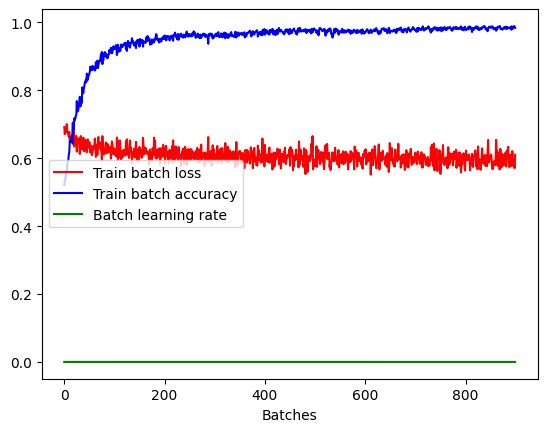

In [ ]:
# Scatter plot
time_axis = np.arange(900)
plt.plot(time_axis, tr_losses, label='Train batch loss', color='red')
plt.plot(time_axis, tr_accs, label='Train batch accuracy', color='blue')
plt.plot(time_axis, lrs, label='Batch learning rate', color='green')
plt.xlabel('Batches')
plt.legend()
plt.show()

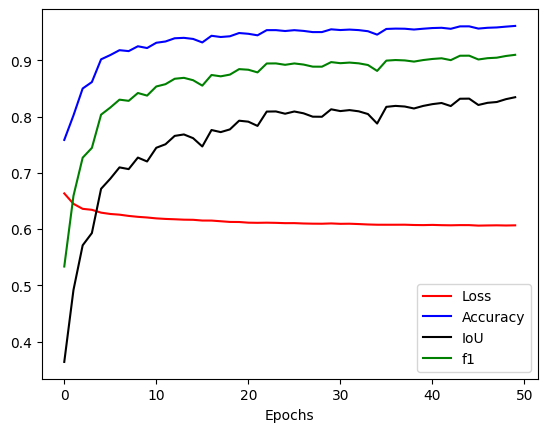

In [ ]:
time_axis = np.arange(50)
plt.plot(time_axis, losses, label='Loss', color='red')
plt.plot(time_axis, accs, label='Accuracy', color='blue')
plt.plot(time_axis, ious, label='IoU', color='black')
plt.plot(time_axis, f1s, label='f1', color='green')
plt.xlabel('Epochs')
plt.legend()
plt.show()


In [ ]:
save_model(model, REPO_DIR + "models/")

Model saved to ml-project-2-pytyeee/models/model_2023-12-15_1.pt
